In [386]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Спарсим содержимое страниц и сохраним в csv

In [62]:
auto_pages = []
for i in xrange(1, 43):
    auto_pages.append('http://turkeytr.net/auto_page-' + str(i) + '.html')

In [63]:
auto_links, auto_titles, auto_addresses = [], [], []
web_path = 'http://turkeytr.net'
for page in auto_pages:
    resp = requests.get(page).content
    soup = BeautifulSoup(resp, 'lxml')
    auto_links += [web_path + k.findNext('a').attrs['href'] for k in soup.findAll('div', {"class":"title"})]
    auto_titles += [k.text for k in soup.findAll('div', {"class":"title"})]
    auto_addresses += [k.text for k in soup.findAll('div', {"class":"address"})]
    
auto_df = pd.DataFrame()
auto_df['link'] = auto_links
auto_df['title'] = auto_titles
auto_df['address'] = auto_addresses

In [64]:
auto_df.head()

,link,title,address
0,http://turkeytr.net/company/asas-otomotiv-ins-...,ASAS OTOMOTIV INS. SAN. VE TIC .A.S.,"Eskibüyükdere Cad., Güvercin Sk., No: 3 34415,..."
1,http://turkeytr.net/company/uzkon-silah-insaat...,UZKON SILAH INSAAT TARIM GIDA SAN. TIC. LTD. STI.,"Musalla Bağları Mah., Kule Cad., Kule Plaza, K..."
2,http://turkeytr.net/company/ukm-kalip-pres-met...,UKM KALIP PRES METAL MAKINA IMALAT SAN. TIC. L...,"Necip Fazıl Mah., Eşref Bitlis Bulvarı, Düzce ..."
3,http://turkeytr.net/company/sevensand-ic-ve-di...,SEVENSAND IC VE DIS TIC. LTD. STI.,"Fevzi Çakmak Mah., 10638 Sk., No: 3/1 Blok No:..."
4,http://turkeytr.net/company/sevensand-automoti...,SEVENSAND AUTOMOTIVE SPARE PARTS,"Fevzi Çakmak Mah., 10638 Sk., No: 3/1 Blok No:..."


In [65]:
acc_pages = []
for i in xrange(1, 74):
    acc_pages.append('http://turkeytr.net/accesories_page-' + str(i) + '.html')

In [66]:
acc_links, acc_titles, acc_addresses = [], [], []
web_path = 'http://turkeytr.net'
for page in auto_pages:
    resp = requests.get(page).content
    soup = BeautifulSoup(resp, 'lxml')
    acc_links += [web_path + k.findNext('a').attrs['href'] for k in soup.findAll('div', {"class":"title"})]
    acc_titles += [k.text for k in soup.findAll('div', {"class":"title"})]
    acc_addresses += [k.text for k in soup.findAll('div', {"class":"address"})]
    
acc_df = pd.DataFrame()
acc_df['link'] = acc_links
acc_df['title'] = acc_titles
acc_df['address'] = acc_addresses

In [7]:
acc_df.head()

,link,title,address
0,http://turkeytr.net/company/asas-otomotiv-ins-...,ASAS OTOMOTIV INS. SAN. VE TIC .A.S.,"Eskibüyükdere Cad., Güvercin Sk., No: 3 34415,..."
1,http://turkeytr.net/company/uzkon-silah-insaat...,UZKON SILAH INSAAT TARIM GIDA SAN. TIC. LTD. STI.,"Musalla Bağları Mah., Kule Cad., Kule Plaza, K..."
2,http://turkeytr.net/company/ukm-kalip-pres-met...,UKM KALIP PRES METAL MAKINA IMALAT SAN. TIC. L...,"Necip Fazıl Mah., Eşref Bitlis Bulvarı, Düzce ..."
3,http://turkeytr.net/company/sevensand-ic-ve-di...,SEVENSAND IC VE DIS TIC. LTD. STI.,"Fevzi Çakmak Mah., 10638 Sk., No: 3/1 Blok No:..."
4,http://turkeytr.net/company/sevensand-automoti...,SEVENSAND AUTOMOTIVE SPARE PARTS,"Fevzi Çakmak Mah., 10638 Sk., No: 3/1 Blok No:..."


In [175]:
auto_df.to_csv('auto_info.csv', index=False, encoding='utf-16')
acc_df.to_csv('accesories_info.csv', index = False, encoding='utf-16')

# 2 часть

In [368]:
auto_df = pd.read_csv('auto_info.csv', encoding='utf-16')
acc_df = pd.read_csv('accesories_info.csv', encoding='utf-16')

auto_df.fillna('', inplace=True)
acc_df.fillna('', inplace=True)

In [369]:
turkey_cities_page = 'https://en.wikipedia.org/wiki/List_of_cities_in_Turkey'
resp = requests.get(turkey_cities_page).content
soup = BeautifulSoup(resp, 'lxml')
city_region_blocks = soup.findAll('tr')[1:582]
cities = [block.findAll('td')[1].text.strip() for block in city_region_blocks]
regions = [block.findAll('td')[-1].text.strip() for block in city_region_blocks]
city_region = zip(cities, regions)
cities, regions = set(cities), set(regions)

Будем искать вхождения названий в адреса

In [370]:
auto_df['region'] = ''
for reg in regions:
    mask = auto_df.address.str.contains(reg)
    auto_df.loc[mask, ['region']] += reg + ' '

#если встретили несколько названий, то берем крайнее правое
#мотивация: названия городов часто встречаются в названиях улиц и находятся левее названия города или региона
def select_word(x, col):
    if len(x[col].strip().split(' ')) < 2:
        return x[col].strip()
    tokens = x[col].strip().split(' ')
    res_ind = -1
    res = ''
    for t in tokens:
        ind = x['address'].find(t.strip())
        if ind > res_ind:
            res_ind, res = ind, t
    return res.strip()
        
    
auto_df['region'] = auto_df.apply(lambda x: select_word(x, 'region'), axis = 1)

Доля заполненных строк:

In [371]:
1. * len(auto_df.query('region != \"\"')) / len(auto_df)

0.7065390749601276

Если посмотреть на данные, то можно заметить две вещи:

    1) Из-за каких-то турецких разногласий в некоторых названиях разные буквы (Izmir - İzmir, Usak - Uşak) 
    - это уменьшает точность
    
    2) Заметное большинство записей адреса имеет формат: дом, город, ил(турецкий район), страна 
    - попробуем использовать это , проверим эту идею на данных, которые мы разметили, и если это работает то 
    заполним пропуски этим методом

In [372]:
def extract_from_address(x, num_tokens, position):
    tokens = x.split(',')
    if len(tokens) < num_tokens:
        return ''
    else:
        region = tokens[-position].split(' ')[-1].strip()
        if len(set(region).intersection(set([str(i) for i in xrange(10)]))) == 0:
            return region
        else:
            return ''
        

auto_df['region_int'] = auto_df.address.apply(lambda x: extract_from_address(x, 3, 2))

Посмотрим на каком кол-ве объектов пересекаются ответы в двух столбцах и на каком кол-ве ответы одинаковы

In [373]:
print len(auto_df.query('region != \'\' and region_int != \'\''))
print len(auto_df.query('region != \'\' and region_int != \'\' and region == region_int '))

85
74


In [374]:
def combine(x, col1, col2):
    if x[col1] == '' and x[col2] == '':
        return ''
    if x[col1] != '':
        return x[col1]
    return x[col2]

auto_df['region_comb'] = auto_df.apply(lambda x: combine(x, 'region', 'region_int'), axis = 1)


Доля размеченных объектов увеличилась:

In [375]:
1. * len(auto_df.query('region_comb != \"\"')) / len(auto_df)

0.7799043062200957

Вполне возможно, что этого хватит для задача определения загруженности регионов компании

In [376]:
auto_df['city'] = ''
for city in cities:
    mask = auto_df.address.str.contains(city)
    auto_df.loc[mask, ['city']] += city + ' '

auto_df['city'] = auto_df.apply(lambda x: select_word(x, 'city'), axis = 1)
auto_df['city_int'] = auto_df.address.apply(lambda x: extract_from_address(x, 4, 3))
auto_df['city_comb'] = auto_df.apply(lambda x: combine(x, 'city', 'city_int'), axis = 1)


In [377]:
1. * len(auto_df.query('city_comb != \"\"')) / len(auto_df)

0.6331738437001595

Доля размеченных по городам меньше, так как в источнике города были с населением больше 7 тысяч. 

In [378]:
auto_df[['title', 'address', 'title', 'region_comb', 'city_comb']].head()

,title,address,title,region_comb,city_comb
0,ASAS OTOMOTIV INS. SAN. VE TIC .A.S.,"Eskibüyükdere Cad., Güvercin Sk., No: 3 34415,...",ASAS OTOMOTIV INS. SAN. VE TIC .A.S.,İstanbul,Kağıthane
1,UZKON SILAH INSAAT TARIM GIDA SAN. TIC. LTD. STI.,"Musalla Bağları Mah., Kule Cad., Kule Plaza, K...",UZKON SILAH INSAAT TARIM GIDA SAN. TIC. LTD. STI.,Konya,Konya
2,UKM KALIP PRES METAL MAKINA IMALAT SAN. TIC. L...,"Necip Fazıl Mah., Eşref Bitlis Bulvarı, Düzce ...",UKM KALIP PRES METAL MAKINA IMALAT SAN. TIC. L...,İstanbul,Düzce
3,SEVENSAND IC VE DIS TIC. LTD. STI.,"Fevzi Çakmak Mah., 10638 Sk., No: 3/1 Blok No:...",SEVENSAND IC VE DIS TIC. LTD. STI.,Konya,Konya
4,SEVENSAND AUTOMOTIVE SPARE PARTS,"Fevzi Çakmak Mah., 10638 Sk., No: 3/1 Blok No:...",SEVENSAND AUTOMOTIVE SPARE PARTS,Konya,Konya


То же самое с acc_df

In [379]:
acc_df['region'] = ''
for city in cities:
    mask = acc_df.address.str.contains(city)
    acc_df.loc[mask, ['region']] += city + ' '

acc_df['region'] = acc_df.apply(lambda x: select_word(x, 'region'), axis = 1)
acc_df['region_int'] = acc_df.address.apply(lambda x: extract_from_address(x, 3, 2))
acc_df['region_comb'] = acc_df.apply(lambda x: combine(x, 'region', 'region_int'), axis = 1)


acc_df['city'] = ''
for city in cities:
    mask = acc_df.address.str.contains(city)
    acc_df.loc[mask, ['city']] += city + ' '

acc_df['city'] = acc_df.apply(lambda x: select_word(x, 'city'), axis = 1)
acc_df['city_int'] = acc_df.address.apply(lambda x: extract_from_address(x, 4, 3))
acc_df['city_comb'] = acc_df.apply(lambda x: combine(x, 'city', 'city_int'), axis = 1)


Теперь о метрике:

Выбор метрики зависит от специфики задачи. 

1) Например, можем выбрать как метрику  долю компаний, для которых правильно определили регион.
Если бы это было метрикой, то в функции extract_from_address я бы поставил один параметр на единицу меньше, и доля размеченных данных стала бы на 10 процентов больше, следовательно, и точность бы возросла. Это произошло бы из-за того, что я бы рассматривал больше случаев, но при этом я бы допускал больше ошибок(из-за разношерстности адресов). Доля верных ответов не учитывает цену ошибки .То есть нужно найти баланс между 
"давать как можно больше правильных ответов" и "быть как можно более надежными" 

Если я правильно понимаю, в данной задаче доля правильных ответов равна полноте(recall)
Если цена ошибки неважна, то можно оптимизировать эту метрику

2)Precision -  доля правильных ответов на данных,на которых мой анализ сработал. Если цена ошибки велика, то можно использовать эту метрику.

3)Можно ввести ограничение на точность(precision >= 0.8) и работать в этих пределах и оптимизировать полноту, либо наоборот.

4) $$F-мера = \frac {2 * precision * recall} {(precision + recall)}$$

# 3 часть

In [380]:
len(set(regions))#кол-во регионов в Турции

81

In [381]:
len(set(auto_df['region_comb']))#кол-во регионов в нашей выборке

51

In [392]:
def before_chart(df, col):
    df[col] = df[col].apply(lambda x: x.lower().title())
    df_filled = df[df[col] != '']
    counts = df_filled[['title', col]].groupby([col], as_index = False).count()
    counts['log_count'] = np.log1p(counts['title'])
    counts = counts.sort_values(['log_count'], ascending=False)
    return counts

In [393]:
auto_counts = before_chart(auto_df.copy(), 'region_comb')
acc_counts = before_chart(acc_df.copy(), 'region_comb')
auto_counts_city = before_chart(auto_df.copy(), 'city_comb')
acc_counts_city = before_chart(acc_df.copy(), 'city_comb')

In [423]:
def plot(data, var, col, label_arg, xlabel_arg, xlim_arg = (0, 6)):
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 15))

    sns.set_color_codes("pastel")
    sns.barplot(x= var, y=col, data=data,
                label=label_arg, color="b")

    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=xlim_arg, ylabel="",
          xlabel=xlabel_arg)

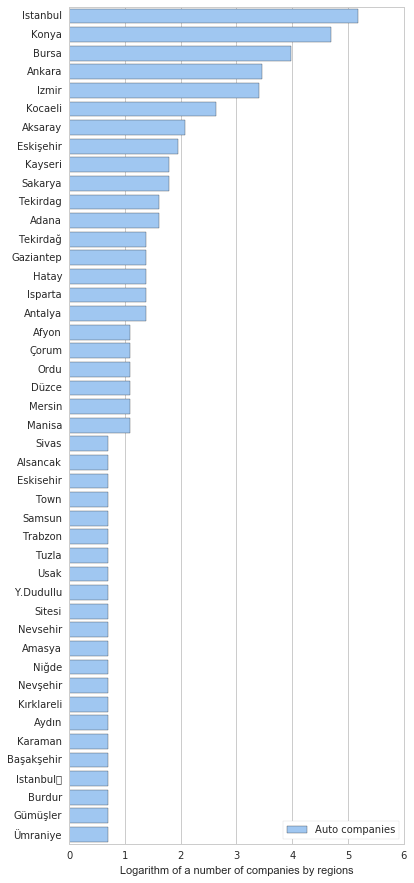

In [398]:
plot(auto_counts, 'log_count','region_comb', 'Auto companies', 'Logarithm of a number of companies by regions')

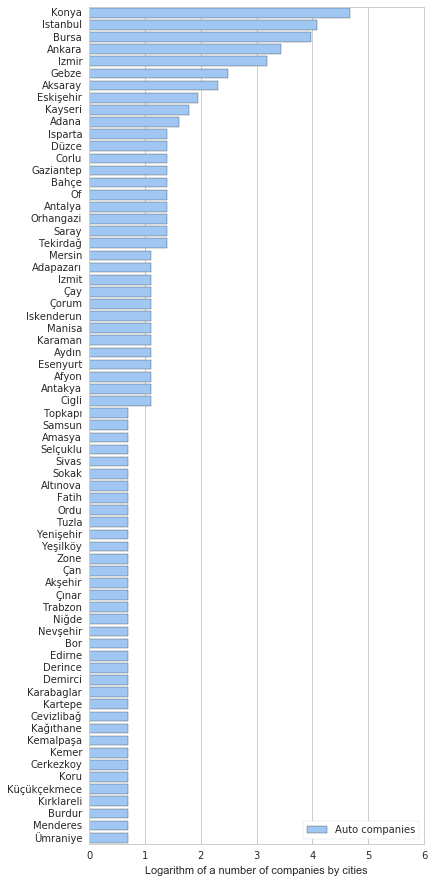

In [399]:
plot(auto_counts_city, 'log_count','city_comb', 'Auto companies', 'Logarithm of a number of companies by cities')

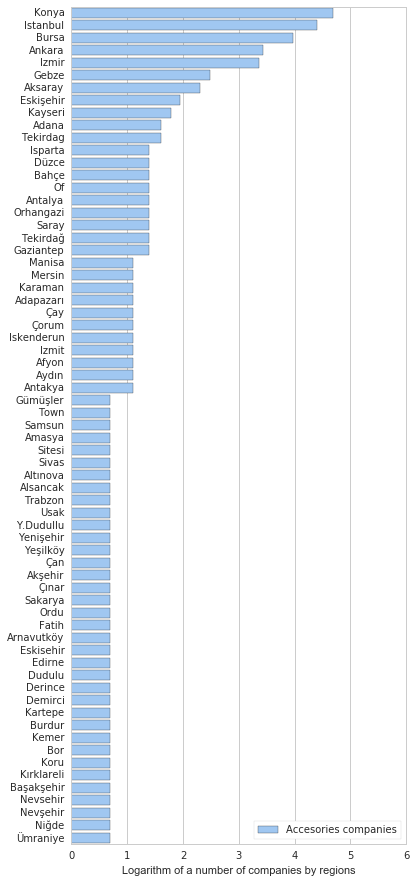

In [401]:
plot(acc_counts, 'log_count','region_comb', 'Accesories companies', 'Logarithm of a number of companies by regions')

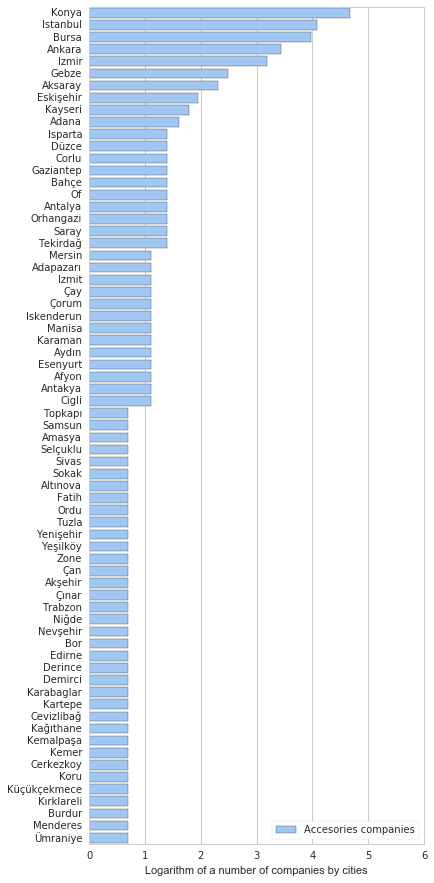

In [402]:
plot(acc_counts_city, 'log_count','city_comb', 'Accesories companies', 'Logarithm of a number of companies by cities')

На графиках видно , в каких регионах и каких городах представлено наибольшее число компаний.

In [420]:
merged_by_regions = pd.merge(auto_counts, acc_counts, on = 'region_comb')
merged_by_regions.fillna(0, inplace=True)
merged_by_regions['intersection'] = merged_by_regions.apply(lambda x: np.min([x['title_x'], x['title_y']]), axis = 1)

merged_by_cities = pd.merge(auto_counts_city, acc_counts_city, on = 'city_comb')
merged_by_cities.fillna(0, inplace=True)
merged_by_cities['intersection'] = merged_by_cities.apply(lambda x: np.min([x['title_x'], x['title_y']]), axis = 1)





Посмотрим на пересечения по регионам и городам

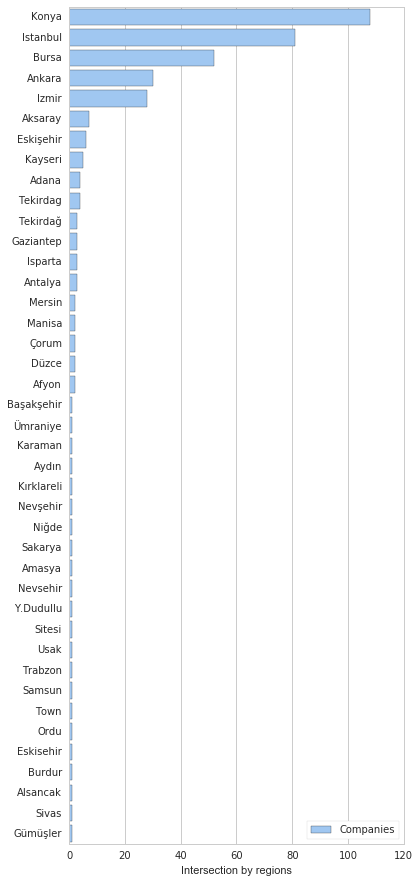

In [433]:
merged_by_regions = merged_by_regions.sort_values(['intersection'], ascending=False)
plot(merged_by_regions, 'intersection','region_comb'
     , 'Companies', 'Intersection by regions', (0,120))


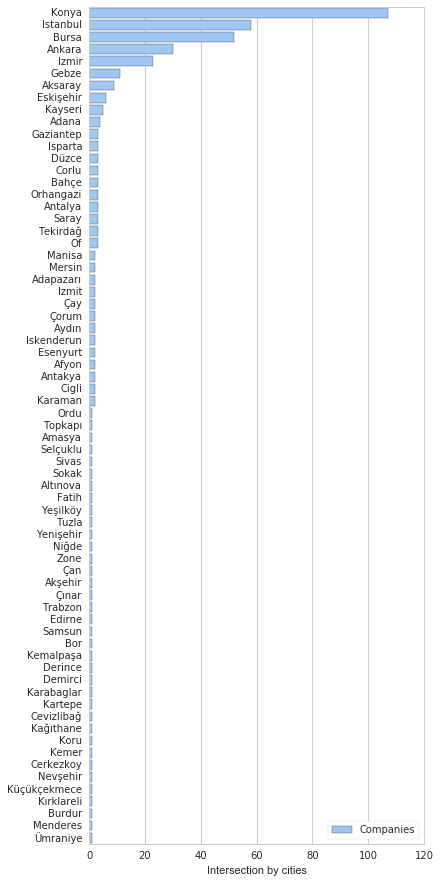

In [435]:
merged_by_cities= merged_by_cities.sort_values(['intersection'], ascending=False)
plot(merged_by_cities, 'intersection','city_comb'
     , 'Companies', 'Intersection by cities', (0,120))
